WRONG CODE: I'm not selecting correctly pre and post shock for mach number 

In [18]:
import sys
sys.path.append('/Users/paolamartire/shocks')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from src.grid_maker import make_grid
from Utilities.operators import the_nearest
from scipy.optimize import fsolve
from shock_zone import shock_direction
from scipy.spatial import KDTree

# %matplotlib widget # (to go back normal %matplotlib inline)
# mpl.rcParams['figure.dpi'] = 100

In [19]:
num = 45
middle_zidx = 22

In [20]:
def the_nearest_inzone(x_zone, y_zone, z_zone, xyz):
    # find the point in the shock zone nearest to xyz
    min_dist = 1e8
    for idx in range(len(x_zone)):
        point = np.array([x_zone[idx], y_zone[idx], z_zone[idx]])
        dist = np.linalg.norm(xyz - point)
        if dist < min_dist:
            min_dist = dist
            final_idx = idx

    return final_idx, point, min_dist

In [21]:
def shock_surface(x_array, y_array, z_array, Tgrid, x_zone, y_zone, z_zone, div, dir, Tzone):
    dx = x_array[1] - x_array[0]
    surface_mach = []
    surface_x = []
    surface_y = []
    surface_z = []
    post_x = []
    post_y = []
    post_z = []
    surface_dir = []

    # loop over all the cells in the shock zone
    for idx in range(len(x_zone)):
        point = [x_zone[idx], y_zone[idx], z_zone[idx]]
        div_v = div[idx]
        dir_sh = dir[idx]

        # you loop on all the cells till you reach the first cell outside the shock zone
        check_zone = 0 # to check if the new point is in the shock zone
        while check_zone < dx:
            # move along shock direction to the POST shock 
            new_point = point - np.multiply(dir_sh,dx)
            
            # find the nearest points in the grid and in the shock zone
            i,j,k, nearest  = the_nearest(x_array, y_array, z_array, new_point, dx, 'point')
            
            final_idx, _, min_dist = the_nearest_inzone(x_zone, y_zone, z_zone, nearest)

            check_zone = min_dist #np.linalg.norm(nearest - nearest_zone)
            point = nearest
                        
        div_next = div[final_idx]
        dir_next = dir[final_idx]

        # if lower div v, you discard the ray.
        if div_next < div_v:
            check_zone = 1e4 # so then you don't take this cell
            continue # so you exit from the while

        # if opposite direction in shocks, discard the ray.
        if np.dot(dir_sh, dir_next) < 0:
            check_zone = 1e4 # so then you don't take this cell
            continue # so you exit from the while

        Tpost = Tgrid[i, j, k]
        Tpre = Tzone[final_idx]
        
        # check if the T jump from Tpre and Tpost is the same as the initial shock direction
        last_shockdir = shock_direction(x_array, y_array, z_array, Tgrid, [i,j,k])
        if np.dot(last_shockdir, dir_sh) > 0:
            surface_x.append(x_zone[idx])
            surface_y.append(y_zone[idx])
            surface_z.append(z_zone[idx])
            post_x.append(x_array[i])
            post_y.append(y_array[j])
            post_z.append(z_array[k])
            surface_dir.append(dir_next)

            def temperature_bump(mach):
                gamma = 5/3
                to_solve =  ((gamma-1) * mach**2 + 2) * (2 * gamma * mach**2 - (gamma-1)) / ((gamma+1)**2 * mach**2) - Tpost/Tpre
                return to_solve
            
            mach = fsolve(temperature_bump, 2)
            surface_mach.append(mach)
        
    surface_x = np.array(surface_x)
    surface_y = np.array(surface_y)
    surface_z = np.array(surface_z)
    post_x = np.array(post_x)
    post_y = np.array(post_y)
    post_z = np.array(post_z)

    return surface_mach, surface_x, surface_y, surface_z, post_x, post_y, post_z, surface_dir


In [22]:
# # With tree, BUT you should know how to compute the gradient

# def shock_surface(x_zone, y_zone, z_zone, div, dir, Tzone):
#     surface_mach = []
#     surface_x = []
#     surface_y = []
#     surface_z = []

#     X = np.load('data/CMx.npy')
#     Y = np.load('data/CMy.npy')
#     Z = np.load('data/CMz.npy')
#     Den = np.load('data/Den.npy')
#     P = np.load('data/P.npy')
    
#     R = np.sqrt(X**2 + Y**2 + Z**2)
#     dx = np.min(R)
#     # make a tree

#     sim_value = [X, Y, Z] 
#     sim_value = np.transpose(sim_value) #array of dim (number_points, 3)
#     sim_tree = KDTree(sim_value) 

#     # loop over all the cells in the shock zone
#     for idx in range(len(x_zone)):
#         print(idx)
#         point = [x_zone[idx], y_zone[idx], z_zone[idx]]
#         div_v = div[idx]
#         dir_sh = dir[idx]

#         # you loop till you reach the first cell outside the shock zone
#         check_zone = 0
#         while check_zone < dx:
#             # along shock direction to the POST shock 
#             new_point = point - np.multiply(dir_sh,dx)
#             dist, idx_tree = sim_tree.query(new_point)
#             nearest = [X[idx_tree], Y[idx_tree], Z[idx_tree]]
#             # find the new point and its nearest points in the grid and in the shock zone
#             next_idx, nearest_zone = the_nearest_inzone(x_zone, y_zone, z_zone, new_point)
#             div_next = div[next_idx]
#             dir_next = dir[next_idx]

#             # if lower div v, you discard the ray. You break the while and don't save the point.
#             if div_next < div_v:
#                 check_zone = 1e4
#                 continue

#             # if opposite direction in shocks, discard the ray
#             if np.dot(dir_sh, dir_next) < 0:
#                 check_zone = dx - 1
#                 continue

#             check_zone = np.linalg.norm(nearest - nearest_zone)
#             point = nearest
            
#         print(check_zone, 3*dx)
            
#         if check_zone < 3*dx:
#             Den_pre = Den[idx_tree]
#             P_pre = P[idx_tree]
#             T_pre = P_pre/Den_pre
#             Tpost = Tzone[next_idx]
            
#             # check if the T jump from Tpre and Tpost is the same as the initial shock direction
#             last_shockdir = shock_direction(x_array, y_array, z_array, Tgrid, [i,j,k])
#             if np.dot(last_shockdir, dir_sh) > 0:
#                 surface_x.append(x_zone[idx])
#                 surface_y.append(y_zone[idx])
#                 surface_z.append(z_zone[idx])
#                 print('xyz')

#                 def temperature_bump(mach):
#                     gamma = 5/3
#                     to_solve =  (mach**2 * (gamma-1) + 2) * (2 * gamma * mach**2 - (gamma-1)) / (mach**2 * (gamma+1)**2) - Tpost/Tpre
#                     return to_solve
                
#                 mach = fsolve(temperature_bump, 1)
#                 surface_mach.append(mach)
#             else:
#                 continue
        
#         else:
#             print('no mach')
#         print('-------')
#     return surface_mach, surface_x, surface_y, surface_z


In [23]:
# Import data
shockzone = np.loadtxt(f'shockzone_zidx{middle_zidx}.txt')
shockdir = np.loadtxt(f'shockdir_zidx{middle_zidx}.txt')

x_zone = shockzone[0]
y_zone = shockzone[1]
z_zone = shockzone[2]
div = shockzone[3]
Tzone = shockzone[4]

x_dir = shockdir[0]
y_dir = shockdir[1]
z_dir = shockdir[2]
dir = []
for i in range(len(x_dir)):
    dir.append([x_dir[i], y_dir[i], z_dir[i]])

In [24]:
# make the grid
_, gridded_den, gridded_T, gridded_P, gridded_Vx, gridded_Vy, gridded_Vz, gridded_V, gridded_Rcell, x_radii, y_radii, z_radii = make_grid(num)


all T=0, bro. CHANGE!
Tree built!


In [25]:
dx = np.min(gridded_Rcell)

In [27]:
surface_mach, surface_x, surface_y, surface_z, post_x, post_y, post_z, surface_dir = shock_surface(x_radii, y_radii, z_radii, gridded_T, x_zone, y_zone, z_zone, div, dir, Tzone)

Text(0, 0.5, '$\\mathcal{M}$')

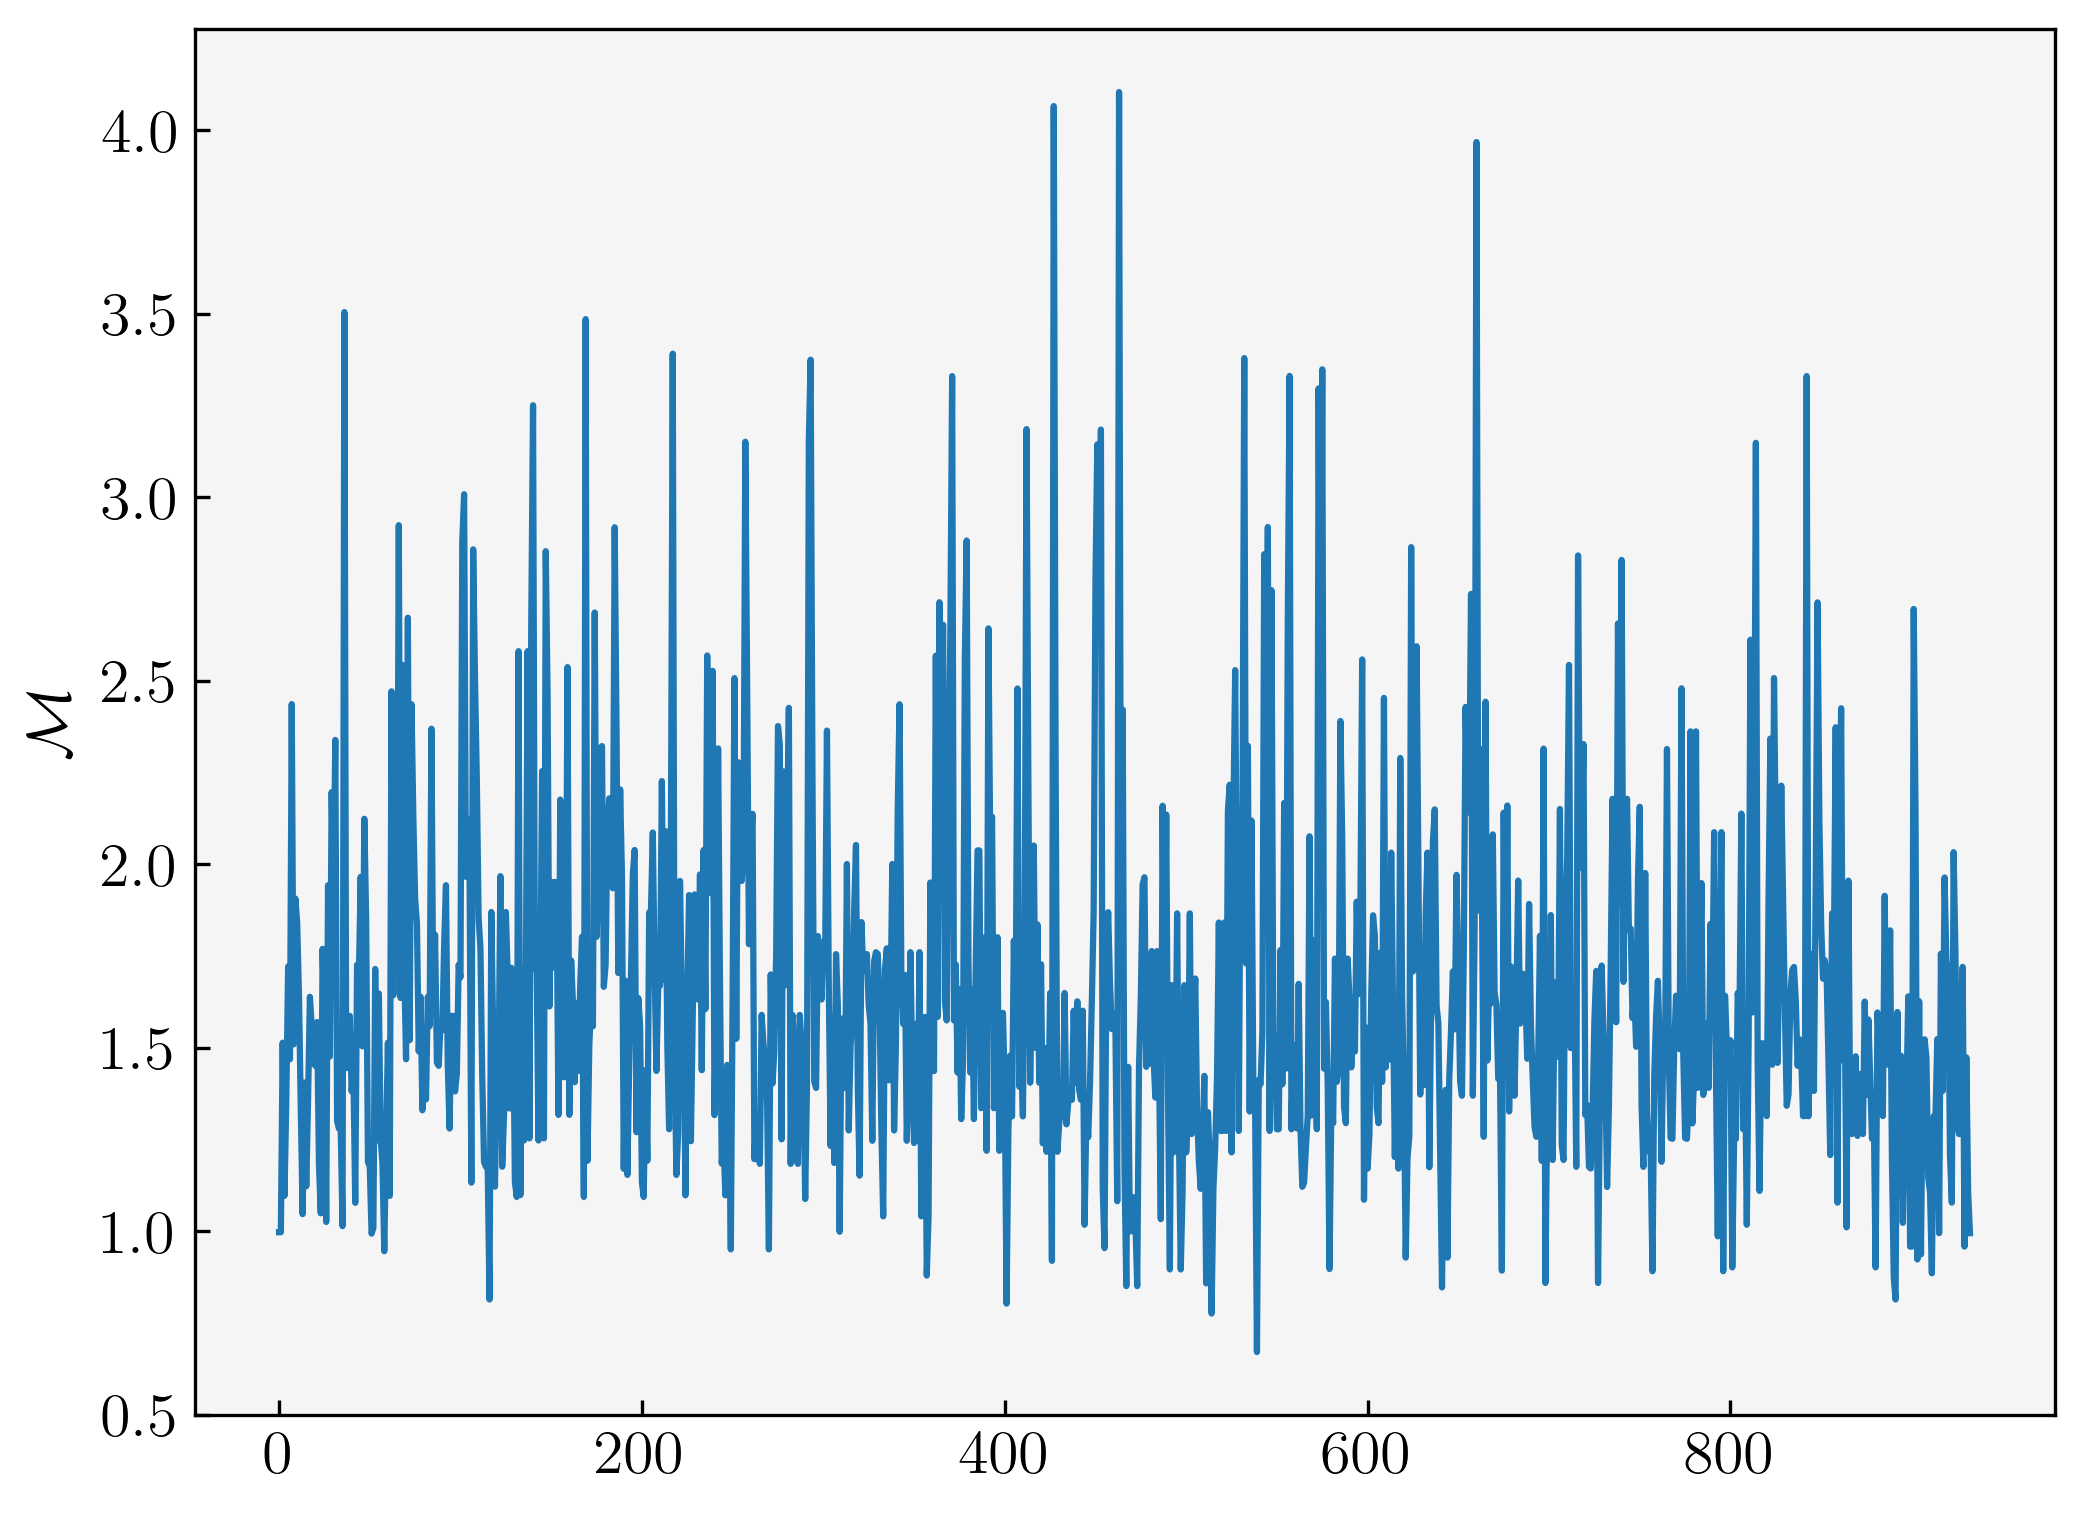

In [37]:
plt.plot(surface_mach)
plt.ylabel(r'$\mathcal{M}$', fontsize = 15)

In [28]:
dx = x_radii[1]-x_radii[0]

In [29]:
surface_shockdir_x = np.zeros(len(surface_dir))
surface_shockdir_y = np.zeros(len(surface_dir))
for i in range(len(surface_shockdir_x)):
    surface_shockdir_x[i] = -surface_dir[i][0]
    surface_shockdir_y[i] = -surface_dir[i][1]

slice_zone = np.logical_and(z_zone<z_radii[middle_zidx]+dx, z_zone>z_radii[middle_zidx]-dx)
zone_cross_x = x_zone[slice_zone]
zone_cross_y = y_zone[slice_zone]

slice_surface = np.logical_and(surface_z<z_radii[middle_zidx]+dx, surface_z>z_radii[middle_zidx]-dx)
surface_cross_x = surface_x[slice_surface]
surface_cross_y = surface_y[slice_surface]

slice_post = np.logical_and(post_z<z_radii[middle_zidx]+dx, post_z>z_radii[middle_zidx]-dx)
zone_post_x = post_x[slice_post]
zone_post_y = post_y[slice_post]
surface_shockdir_x = surface_shockdir_x[slice_post]
surface_shockdir_y = surface_shockdir_y[slice_post]


Text(0.5, 1.0, 'z = 0.0')

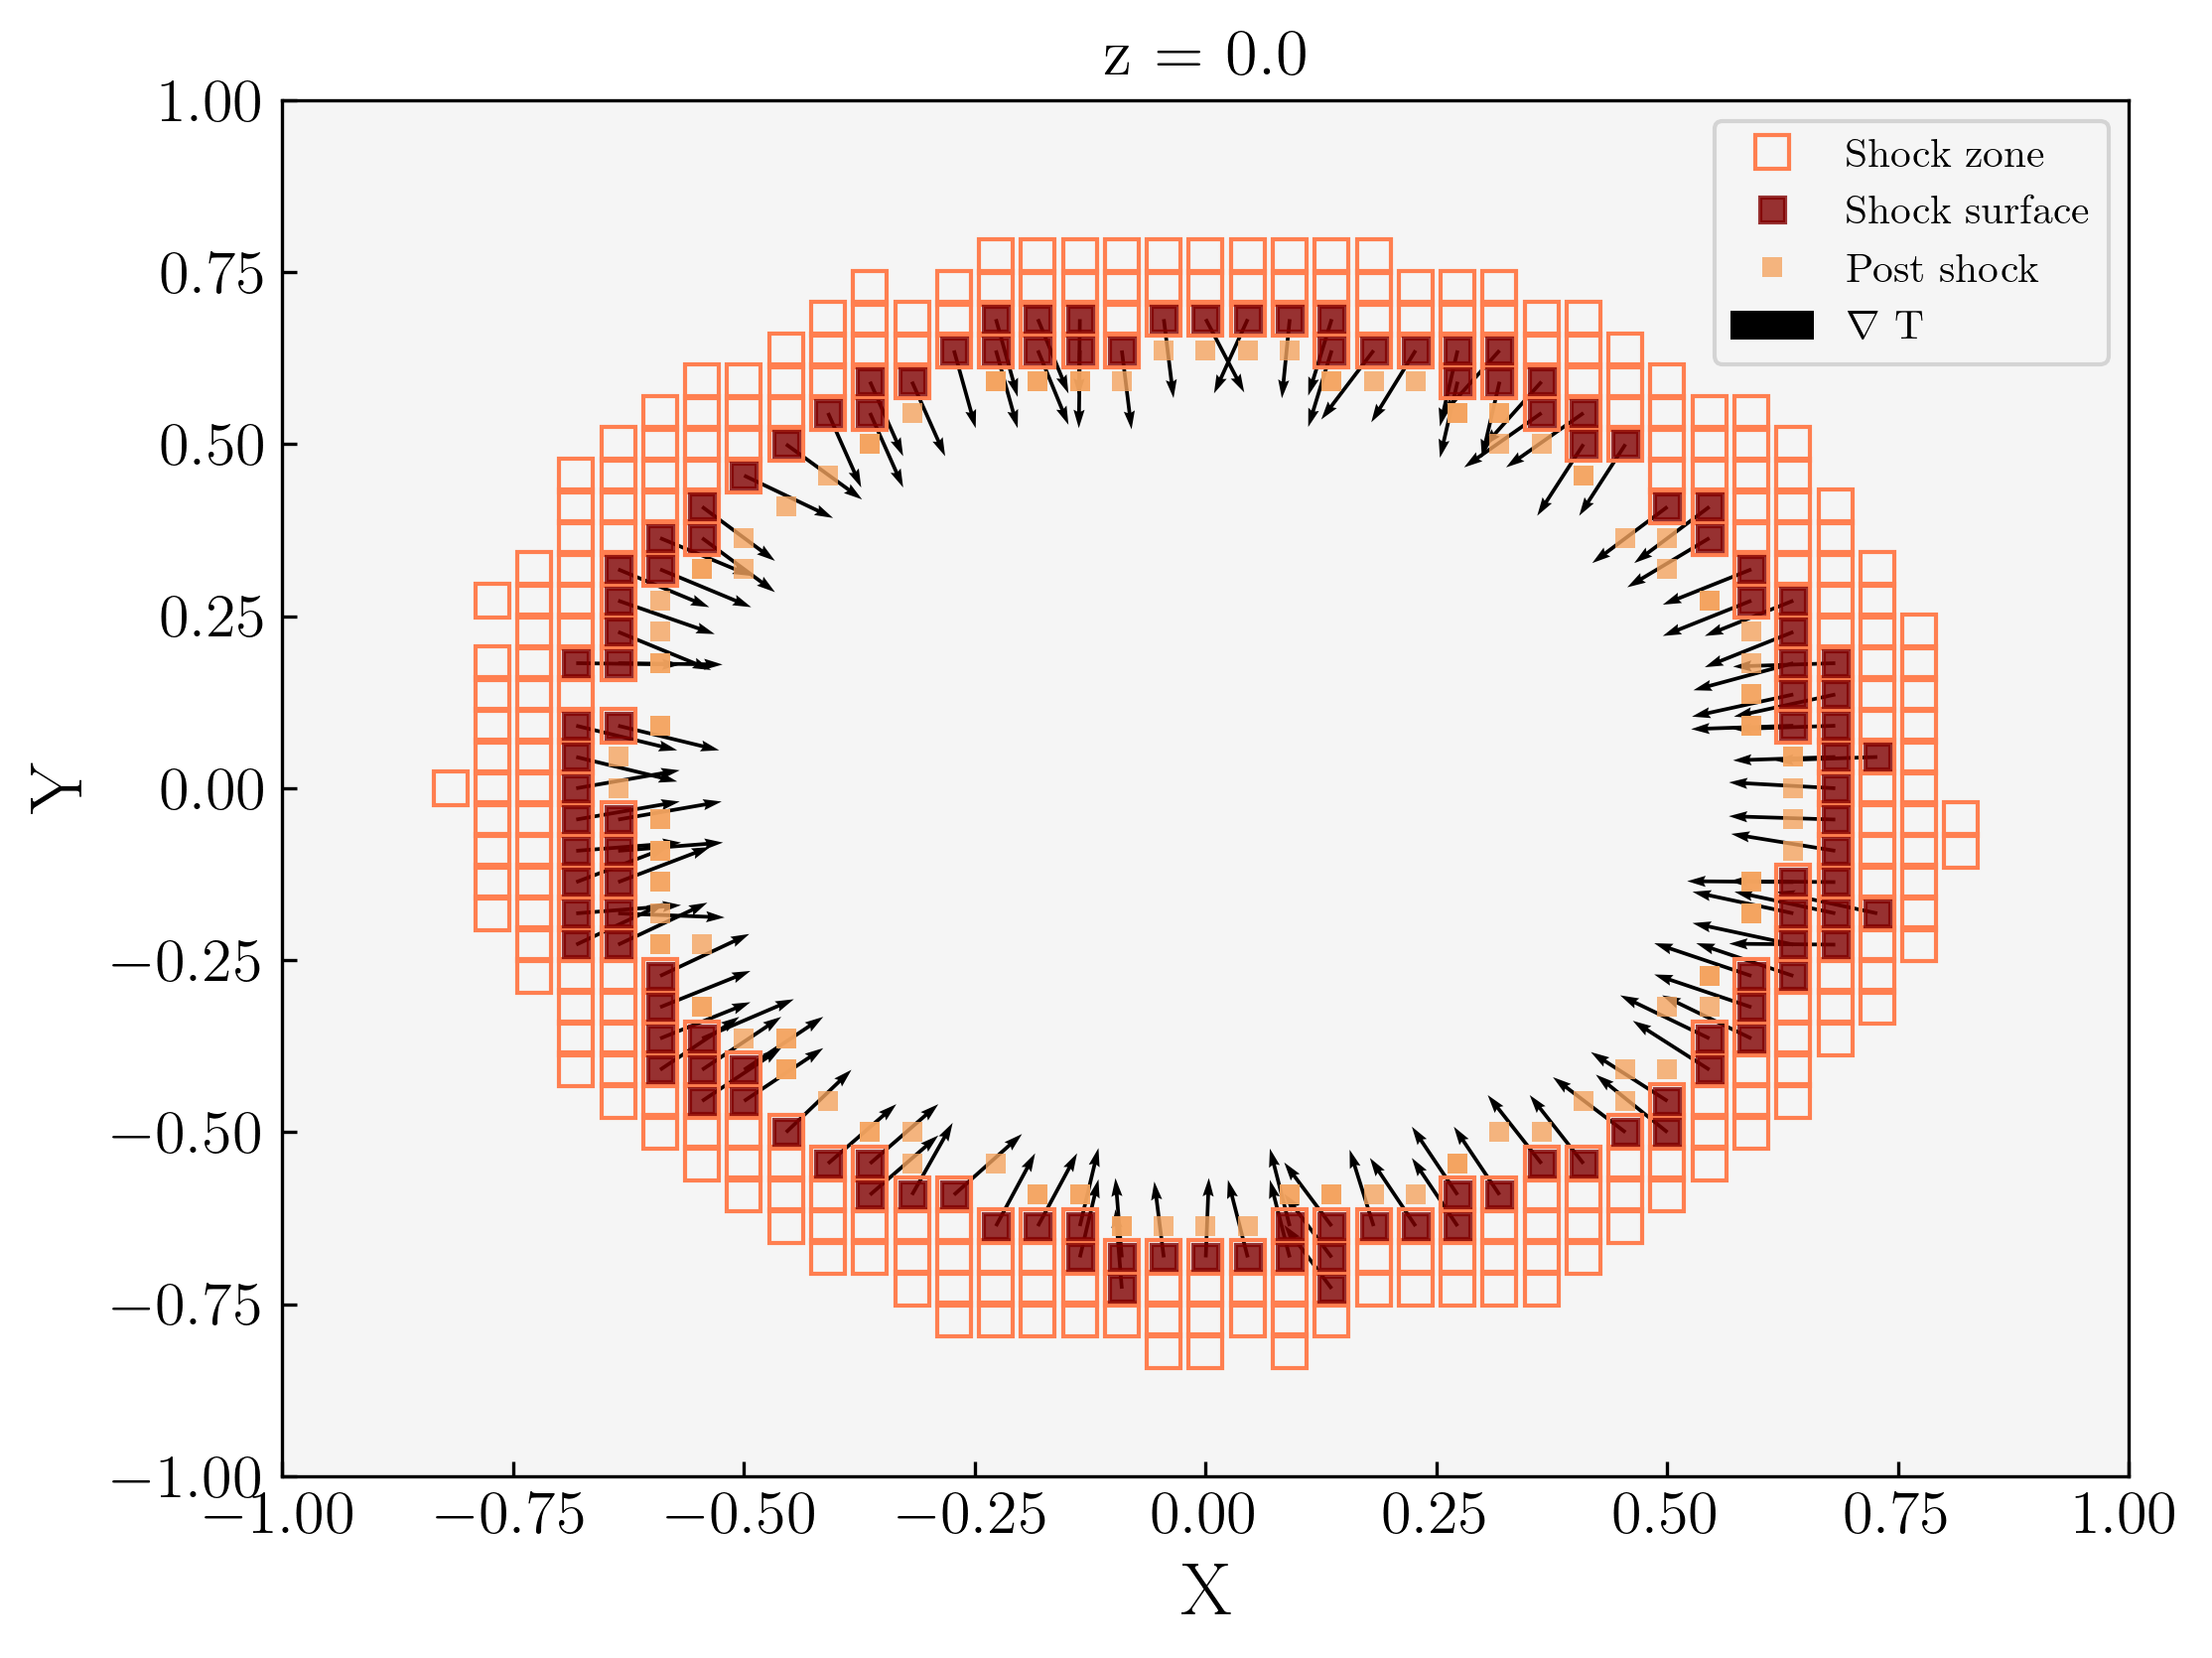

In [30]:
fig, ax = plt.subplots(1,1)
ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 8, markeredgecolor='coral', label = 'Shock zone')
ax.plot(surface_cross_x, surface_cross_y, 'ks', markerfacecolor='maroon', ms = 6, markeredgecolor='maroon',  alpha = 0.8, label = 'Shock surface')
ax.plot(zone_post_x, zone_post_y, 'ks', markerfacecolor='sandybrown', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Post shock')
ax.quiver(surface_cross_x, surface_cross_y, surface_shockdir_x, surface_shockdir_y,  width = 0.002, color = 'k', angles='xy', scale_units='xy', label = r'$\nabla$ T')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel('X', fontsize = 18)
ax.set_ylabel('Y', fontsize = 18)
ax.legend()
ax.set_title(f'z = {z_radii[middle_zidx]}', fontsize = 16)
# plt.savefig(f'Figs/shocksurface_zidx{middle_zidx}.png')